Compare no power control with UD-DPC in the noise-limited and interferencelimited scenarios. Set $P_{max}$ = 30 dBm, $P_{min}$ = 0 dBm and the discrete power control
update step as $\mu$ = 1 dBm. As for the target SINR required in UD-DPC, let us assume
the value corresponding to the QoS target of 100 Mbps at cell border under 100 MHz
which equates to 
$\gamma_t$ = 1. All other simulation parameters are kept in the same values
used in previous exercises. What are your observations? Did fixed-target SINR-based
power control (UD-DPC) help in any of the scenarios?


In [674]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(12)

In [675]:
# Função que transforma Linear para dB
def lin2db(x):
    return 10 * np.log10(x)

# Função que transforma dB para Linear
def db2lin(x):
    return 10 ** (x / 10)

# Função que transforma Linear para dBm (watt)
def lin2dbm(x):
    return 10 * np.log10(x * 1000)

# Função que transforma dBm para Linear (watt)
def dbm2lin(x):
    return 10**(x / 10) / 1000

In [676]:
# Função que define os eixos x e y da CDF
def cdf(dados):
    '''Função que calcula a Cumulative Distribution Function (CDF) de um conjunto de dados.
    Parâmetros:
    dados: array. Conjunto de dados.
    Retorno:
    x: array. Dados ordenados.
    y: array. Probabilidade acumulada de cada dado.'''

    x = np.sort(dados)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

In [677]:
# Função que gera as coordenadas dos APs
def distribuir_APs(num_aps, area):
    '''Distributes Access Points (APs) evenly within a square area.
    
    Parameters:
    num_aps (int): The number of APs to distribute. Must be a perfect square.
    area (int): The length of the side of the square area in which to distribute the APs.
    
    Returns:
    np.array: An array of coordinates for the APs, or None if num_aps is not a perfect square.'''
    
    if num_aps not in [1, 4, 9, 16, 25, 36, 49, 64, 100]:
        return None

    tamanho_quadrado = area
    lado_quadrado = int(np.sqrt(num_aps))

    tamanho_celula = tamanho_quadrado // lado_quadrado

    # Criar coordenadas usando meshgrid
    x, y = np.meshgrid(np.arange(0.5 * tamanho_celula, tamanho_quadrado, tamanho_celula),
                      np.arange(0.5 * tamanho_celula, tamanho_quadrado, tamanho_celula))

    coordenadas_APs = np.column_stack((x.ravel(), y.ravel()))

    return coordenadas_APs

In [678]:
# Função que gera a distância entre a UE e a AP
def dAPUE(x_coord, y_coord, ap_coord, d_reference=1):
  '''Calculate the Euclidean distance between a user equipment (UE) and an access point (AP).
    
    Parameters:
    ue_coords (tuple): A tuple (x_coord, y_coord) representing the coordinates of the UE.
    ap_coords (np.array): An array containing the coordinates of the APs.
    
    Returns:
    float: The Euclidean distance between the UE and the AP. If the euclidean distance is less than 1, return 1.
  '''
  dAPUE = np.linalg.norm(np.array([x_coord, y_coord]) - ap_coord)
  if dAPUE < d_reference:
    return d_reference
  else:
    return dAPUE

In [679]:
#Função que define o shadowing para cada usuário
def find_shadowing(standard_shadow, ues, aps):
    '''Generate a shadowing value for a user.

    Parameters:
    standard_shadow (float): The standard deviation of the shadowing values.
    ues (int): The number of user equipment (UE) in the simulation.
    aps (int): The number of access points (APs) in the

    Returns:
    np.array: A 2D array of shadowing values for each UE and AP.
    '''

    shadowing = np.random.lognormal(0, standard_shadow, (ues, aps))

    return shadowing 

In [680]:
def find_fastfading(standard_fading, ues, aps, channels):
    '''Função que calcula o fast fading para um dado usuário.
    
    Parâmetros:
    standard_fading (float): O desvio padrão da distribuição normal.
    ues (int): O número de usuários.
    aps (int): O número de pontos de acesso.
    channels (int): O número de canais.
    
    Retorna:
    np.array: Um array 3D com os valores de fast fading para cada usuário, ponto de acesso e canal.
    '''

    fast_fading = np.sqrt( (standard_fading * np.random.randn(channels, ues, aps))**2 + (standard_fading * np.random.randn(channels, ues, aps))**2 )

    return fast_fading

In [681]:
# Função que calcula o path gain com a distância, shadowing e fast fading
def find_pathgain(dist, shadowing, fastfading):
    ambiente_const = 1e-4
    pathloss_const = 4


    path_gain_result = (shadowing * (ambiente_const / (dist ** pathloss_const))) * fastfading **2

    
    return path_gain_result

In [682]:
def calculate_sinr(banda, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, p_t, area, x_coord, y_coord):
    '''Função que calcula a SINR para múltiplos UEs e APs em diferentes canais.

    i-th AP, j-th UE, c-th channel
    
    Lembrando que [channels, ues, aps] é a dimensão de fastfading, logo as dimensões da matriz path_gain é [channels, ues, aps]. 

    Parâmetros:
    banda (float): Largura de banda total.
    K_0 (float): Constante de ruído.
    aps (int): Número de APs.
    ues (int): Número de UEs.
    channels (int): Número de canais.
    sigma_shadowing (float): Desvio padrão para o shadowing.
    sigma_fastfading (float): Desvio padrão para o fast fading.
    p_t (np.array): Potência de transmissão de cada UE.
    rrm_index (int): Índice para o tipo de algoritmo de alocação de recursos.
    area (float): Área de distribuição dos APs.
    
    Retorna:
    np.array: O valor do SINR para cada UE.
    '''
    # Inicializações
    aps_position = distribuir_APs(aps, area)
    dist = np.zeros((ues, aps))

    # Shadowing já definido
    shadowing = np.array([[5.3434e-2, 2.8731e-1, 1.9691e-2, 7.3013e-1],
                          [3.2318, 1.5770, 2.6449e-1, 5.6379],
                          [6.1470e-3, 1.1424, 2.6826e-1, 4.5709],
                          [1.3485e-1, 4.6690e-1, 7.8250e-1, 1.6742]])
    
    # Fast fading já definido, deixando-o no formato [channels, ues, aps]
    fastfading = np.array([[1.248699, 3.248041, 0.772754, 0.708962], 
                           [0.498887, 0.104890, 0.647280, 0.940906], 
                           [0.382966, 0.682700, 1.891256, 0.327100], 
                           [0.065737, 0.649500, 1.981107, 1.259538]]).reshape(channels, ues, aps)
    
    power_trans = p_t
    power_noise = np.ones(ues) * (K_0 * banda / channels)


    # Distância entre UEs e APs
    for ue_index in range(ues):
        for ap_index in range(aps):
            dist[ue_index][ap_index] = dAPUE(x_coord[ue_index], y_coord[ue_index], aps_position[ap_index])

    path_gain = find_pathgain(dist, shadowing, fastfading)

    # Cálculo do SINR
    sinr_total = np.zeros(path_gain.shape)
    sinr_ue = np.zeros(path_gain.shape[1])

    for ue_index in range(path_gain.shape[1]):
        for channel_index in range(path_gain.shape[0]):
            for ap_index in range(path_gain.shape[2]):
                # Calculando a potência recebida no canal atual
                power_received = np.abs(path_gain[channel_index, ue_index, ap_index]) * power_trans[ue_index]
    
                # Calculando a interferência no mesmo canal
                interference_sum = 0
                for other_ue_index in range(path_gain.shape[1]):
                    if other_ue_index != ue_index:  # Se não for o mesmo usuário
                        interference_sum += np.abs(path_gain[channel_index, other_ue_index, ap_index]) * power_trans[other_ue_index]

                # Cálculo da SINR para o canal, UE e AP atuais
                sinr_total[channel_index, ue_index, ap_index] = power_received / (interference_sum + power_noise[ue_index])

    # Selecionar o maior valor de SINR para cada UE
    for ue_index in range(sinr_total.shape[1]):
        sinr_ue[ue_index] = np.max(sinr_total[:, ue_index, :])

    return sinr_ue


In [683]:
def updown_dpc(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, banda, K_0, area, sigma_shadowing, sigma_fastfading, x_coord, y_coord): 
    # Inicializa posições dos APs e distâncias
    aps_position = distribuir_APs(aps, area)
    dist = np.zeros((ues, aps))

    # Definindo o shadowing e o fast fading como matrizes fixas
    shadowing = np.array([[5.3434e-2, 2.8731e-1, 1.9691e-2, 7.3013e-1],
                          [3.2318, 1.5770, 2.6449e-1, 5.6379],
                          [6.1470e-3, 1.1424, 2.6826e-1, 4.5709],
                          [1.3485e-1, 4.6690e-1, 7.8250e-1, 1.6742]])
    fastfading = np.array([[1.248699, 3.248041, 0.772754, 0.708962], 
                           [0.498887, 0.104890, 0.647280, 0.940906], 
                           [0.382966, 0.682700, 1.891256, 0.327100], 
                           [0.065737, 0.649500, 1.981107, 1.259538]]).reshape(channels, ues, aps)

    # Calculando a distância entre UEs e APs
    for ue_index in range(ues):
        for ap_index in range(aps):
            dist[ue_index][ap_index] = dAPUE(x_coord[ue_index], y_coord[ue_index], aps_position[ap_index])

    # Calculando o path gain
    path_gain = find_pathgain(dist, shadowing, fastfading)

    # Inicializa vetores de potência e alocação
    transmit_power = power_trans_max * np.ones((path_gain.shape[1], 1))
    power_sum = np.zeros(time)
    power_evolution = np.zeros((path_gain.shape[1], time))
    sinr_evolution = np.zeros((path_gain.shape[1], time))

    # Loop para cada instante de tempo
    for time_index in range(time):
        power_sum[time_index] = sum(transmit_power.flatten())

        # Salvar a evolução da potência para cada UE
        power_evolution[:, time_index] = transmit_power.flatten()

        # Calcula a SINR para cada usuário no tempo atual
        sinr_ue = calculate_sinr(banda, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, dbm2lin(transmit_power), area, x_coord, y_coord)
        sinr_ue = lin2db(sinr_ue).reshape((ues, 1))

        # Salvar a evolução da SINR para cada UE
        sinr_evolution[:, time_index] = sinr_ue.flatten()

        # Atualiza a potência com base no erro entre a SINR alvo e a SINR atual
        transmit_power = transmit_power + step * np.sign(sinr_alvo - sinr_ue)

        # Aplica os limites de potência
        transmit_power = np.clip(transmit_power, power_trans_min, power_trans_max)

    return power_evolution, transmit_power, power_sum, sinr_evolution


In [684]:
def find_capacity(sinr, banda, channels):
    '''Função que calcula a capacidade de um dado canal.
    
    Parâmetros:
    sinr (array): A relação sinal ruído mais interferência.
    banda (int): A largura de banda do canal.    
    channels (int): O número de canais.
    Retorna:
    list: A capacidade do canal.'''

    capacity = banda * np.log2(1 + sinr)

    # Deixado no formato [channels, ues]
    capacity = capacity.reshape(channels, -1)

    return capacity

In [685]:
def noise_limited(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, banda, K_0, area, sigma_shadowing, sigma_fastfading):
    
    x_coord = np.array([225.83, 566.79, 765.51, 265.95])
    y_coord = np.array([203.33, 321.88, 146.88, 702.39])

    # Deixando a SINR no formato [ues, time] e a capacidade no formato [ues, time]
    sinr_max_vector = np.zeros((ues, time))
    sinr_dpc_vector = np.zeros((ues, time))
    capacity_max_vector = np.zeros((ues, time))
    capacity_dpc_vector = np.zeros((ues, time))

    # Definindo os dois tipos de controle de potência a ser utilizado:
    # 1. UpDownDPC
    transmit_power_dpc = updown_dpc(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, banda, K_0, area, sigma_shadowing, sigma_fastfading, x_coord, y_coord)
    # Deixando a potência no formato [ues, time]
    transmit_power_dpc = transmit_power_dpc[0].reshape(ues, time) # Esse formato foi escolhido para facilitar a visualização dos dados e achado de maneira impirica

    # 2. Power Max
    transmit_power_max = power_trans_max*np.ones((ues, time))



    for time_index in range (time):

        # Calculando a SINR para cada usuário utilizando o Power Max
        trans_power_max_lin = dbm2lin(transmit_power_max[:, time_index])

        sinr_max = calculate_sinr(banda, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, trans_power_max_lin, area, x_coord, y_coord)

        # Calculando a capacidade para cada usuário utilizando o Power Max
        capacity_max = find_capacity(sinr_max, banda, channels)

        trans_power_dpc_lin = dbm2lin(transmit_power_dpc[:,time_index])

        # Calculando a SINR para cada usuário utilizando o UpDownDPC
        sinr_dpc = calculate_sinr(banda, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, trans_power_dpc_lin, area, x_coord, y_coord)

        # Calculando a capacidade para cada usuário utilizando o UpDownDPC
        capacity_dpc = find_capacity(sinr_dpc, banda, channels)

        # Alocando os valores de SINR e capacidade para cada usuário para cada momento
        sinr_max_vector[:, time_index] = sinr_max
        sinr_dpc_vector[:, time_index] = sinr_dpc
        capacity_max_vector[:, time_index] = capacity_max
        capacity_dpc_vector[:, time_index] = capacity_dpc

    return sinr_max_vector, sinr_dpc_vector, capacity_max_vector, capacity_dpc_vector



        


        

In [686]:
bandwidth , transmit_power, d_min, K_0 = 100e6, 1, 1, 1e-20 # Em MHz, mW, metros, mW/Hz respectivamente
aps, ues, channels = 4, 4, 1
area_noiselimited = 1000
area_interferencelimited = 100
sigma_shadowing = 2
sigma_fastfading = 1/np.sqrt(2)


In [687]:
power_trans_max = 30 # Em dBm
power_trans_min = 0 # Em dBm
step = 1 # Em dBm

In [688]:
# Definindo o SINR alvo
sinr_alvo = 1

# Definindo o tempo de simulação
time = 50

# Fazendo a simulação
sinr_max_vector, sinr_dpc_vector, capacity_max_vector, capacity_dpc_vector = noise_limited(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, bandwidth, K_0, area_noiselimited, sigma_shadowing, sigma_fastfading)

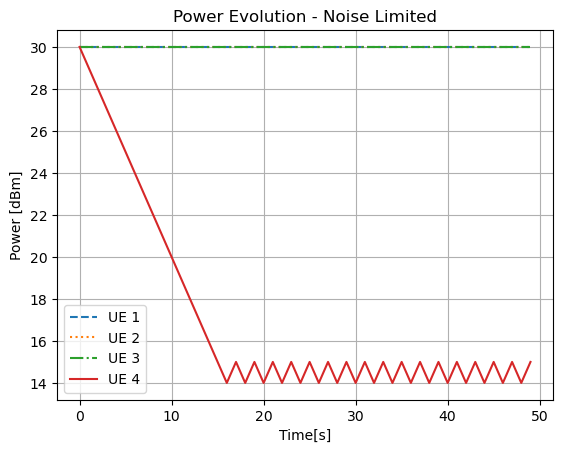

[[30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.
  30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30. 30.]
 [30. 29. 28. 27. 26. 25. 24. 23. 22. 21. 20. 19. 18. 17. 16. 15. 14. 15.
  14. 15. 14. 15. 14. 15. 14. 15. 14. 15. 14. 15. 14. 15. 14. 15. 14. 15.
  14. 15. 14. 15. 14. 15. 14. 15. 14. 15. 14. 15. 14. 15.]]


In [689]:
# Plotando a evolução da potência de transmissão

x_coord = [225.83, 566.79, 765.51, 265.95]
y_coord = [203.33, 321.88, 146.88, 702.39]

a = updown_dpc(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, bandwidth, K_0, area_noiselimited, sigma_shadowing, sigma_fastfading, x_coord, y_coord)
# Descobrindo qual as dimensões de a

a = a[0]



plt.figure()
plt.plot(a[0], label='UE 1', linestyle='--')
plt.plot(a[1], label='UE 2', linestyle=':')
plt.plot(a[2], label='UE 3', linestyle='-.')
plt.plot(a[3], label='UE 4')
plt.grid()
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Power [dBm]')
plt.title('Power Evolution - Noise Limited')
plt.show()

print(a)


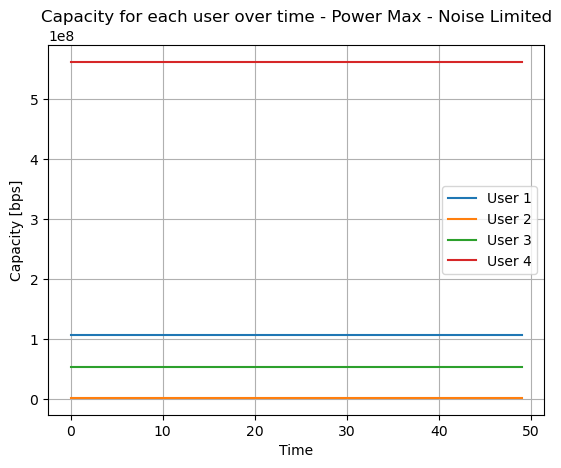

In [690]:
# Plotando a capacidade para cada usuário para cada momento utilizando o Power Max
plt.figure()
plt.plot(capacity_max_vector[0, :], label='User 1')
plt.plot(capacity_max_vector[1, :], label='User 2')
plt.plot(capacity_max_vector[2, :], label='User 3')
plt.plot(capacity_max_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - Power Max - Noise Limited')
plt.grid()
plt.show()

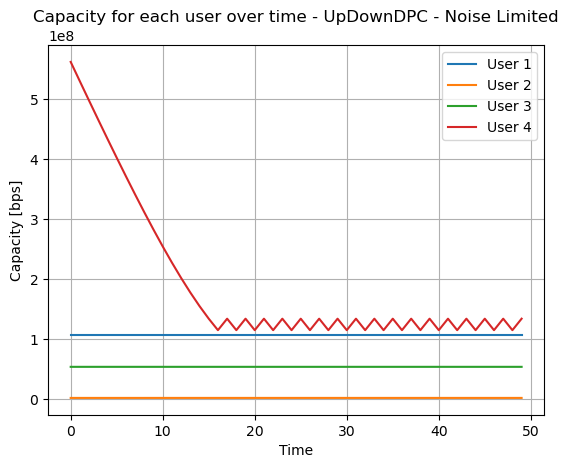

In [691]:
# Plotando a capacidade para cada usuário para cada momento utilizando o UpDownDPC

plt.figure()
plt.plot(capacity_dpc_vector[0, :], label='User 1')
plt.plot(capacity_dpc_vector[1, :], label='User 2')
plt.plot(capacity_dpc_vector[2, :], label='User 3')
plt.plot(capacity_dpc_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - UpDownDPC - Noise Limited')
plt.grid()
plt.show()


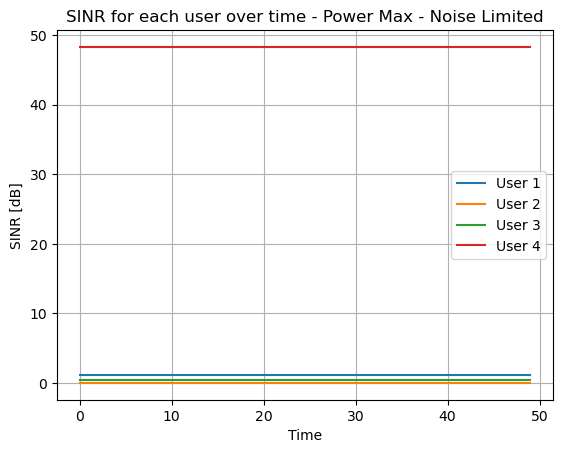

In [692]:
# Plotando a SINR para cada usuário para cada momento utilizando o Power Max
plt.figure()
plt.plot(sinr_max_vector[0, :], label='User 1')
plt.plot(sinr_max_vector[1, :], label='User 2')
plt.plot(sinr_max_vector[2, :], label='User 3')
plt.plot(sinr_max_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - Power Max - Noise Limited')
plt.grid()
plt.show()

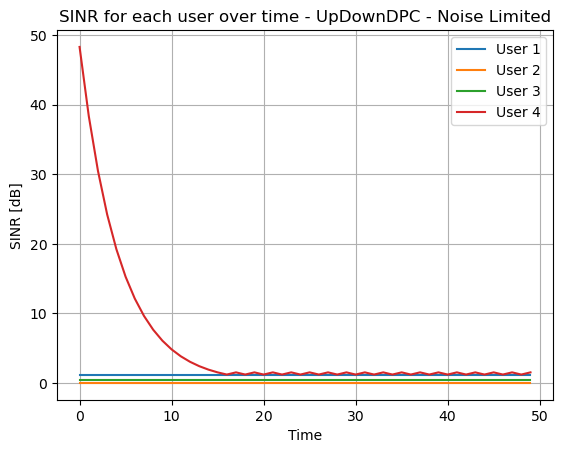

In [693]:
# Plotando a SINR para cada usuário para cada momento utilizando o UpDownDPC
plt.figure()
plt.plot(sinr_dpc_vector[0, :], label='User 1')
plt.plot(sinr_dpc_vector[1, :], label='User 2')
plt.plot(sinr_dpc_vector[2, :], label='User 3')
plt.plot(sinr_dpc_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - UpDownDPC - Noise Limited')
plt.grid()
plt.show()

In [694]:
def interference_limited(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, banda, K_0, area, sigma_shadowing, sigma_fastfading):
    
    x_coord = np.array([22.583, 56.679, 76.551, 26.595])
    y_coord = np.array([20.333, 32.188, 14.688, 70.239])

    # Deixando a SINR no formato [ues, time] e a capacidade no formato [ues, time]
    sinr_max_vector = np.zeros((ues, time))
    sinr_dpc_vector = np.zeros((ues, time))
    capacity_max_vector = np.zeros((ues, time))
    capacity_dpc_vector = np.zeros((ues, time))

    # Definindo os dois tipos de controle de potência a ser utilizado:
    # 1. UpDownDPC
    transmit_power_dpc = updown_dpc(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, banda, K_0, area, sigma_shadowing, sigma_fastfading, x_coord, y_coord)
    # Deixando a potência no formato [ues, time]
    transmit_power_dpc = transmit_power_dpc[0].reshape(ues, time) # Esse formato foi escolhido para facilitar a visualização dos dados e achado de maneira impirica

    # 2. Power Max
    transmit_power_max = power_trans_max*np.ones((ues, time))



    for time_index in range (time):

        # Calculando a SINR para cada usuário utilizando o Power Max
        trans_power_max_lin = dbm2lin(transmit_power_max[:, time_index])

        sinr_max = calculate_sinr(banda, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, trans_power_max_lin, area, x_coord, y_coord)

        # Calculando a capacidade para cada usuário utilizando o Power Max
        capacity_max = find_capacity(sinr_max, banda, channels)

        trans_power_dpc_lin = dbm2lin(transmit_power_dpc[:,time_index])

        # Calculando a SINR para cada usuário utilizando o UpDownDPC
        sinr_dpc = calculate_sinr(banda, K_0, aps, ues, channels, sigma_shadowing, sigma_fastfading, trans_power_dpc_lin, area, x_coord, y_coord)

        # Calculando a capacidade para cada usuário utilizando o UpDownDPC
        capacity_dpc = find_capacity(sinr_dpc, banda, channels)

        # Alocando os valores de SINR e capacidade para cada usuário para cada momento
        sinr_max_vector[:, time_index] = sinr_max
        sinr_dpc_vector[:, time_index] = sinr_dpc
        capacity_max_vector[:, time_index] = capacity_max
        capacity_dpc_vector[:, time_index] = capacity_dpc

    return sinr_max_vector, sinr_dpc_vector, capacity_max_vector, capacity_dpc_vector
        

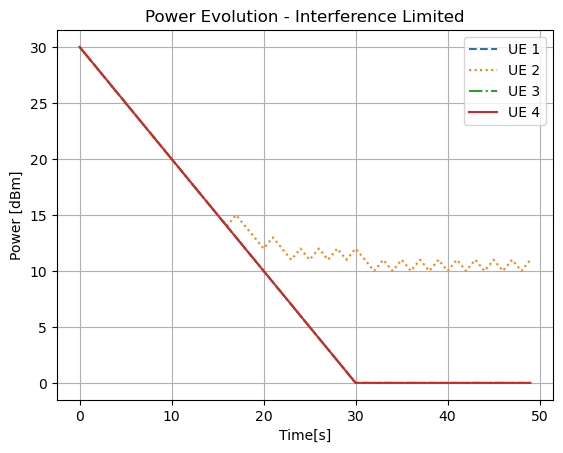

In [695]:
# Plotando a evolução da potência de transmissão

x_coord = [22.583, 56.679, 76.551, 26.595]
y_coord = [20.333, 32.188, 14.688, 70.239]

a_interference = updown_dpc(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, bandwidth, K_0, area_interferencelimited, sigma_shadowing, sigma_fastfading, x_coord, y_coord)

a_interference = a_interference[0]

plt.figure()
plt.plot(a_interference[0], label='UE 1', linestyle='--')
plt.plot(a_interference[1], label='UE 2', linestyle=':')
plt.plot(a_interference[2], label='UE 3', linestyle='-.')
plt.plot(a_interference[3], label='UE 4')
plt.grid()
plt.legend()
plt.xlabel('Time[s]')
plt.ylabel('Power [dBm]')
plt.title('Power Evolution - Interference Limited')
plt.show()


In [696]:
sinr_max_vector, sinr_dpc_vector, capacity_max_vector, capacity_dpc_vector = interference_limited(aps, ues, channels, power_trans_max, power_trans_min, step, sinr_alvo, time, bandwidth, K_0, area_interferencelimited, sigma_shadowing, sigma_fastfading)


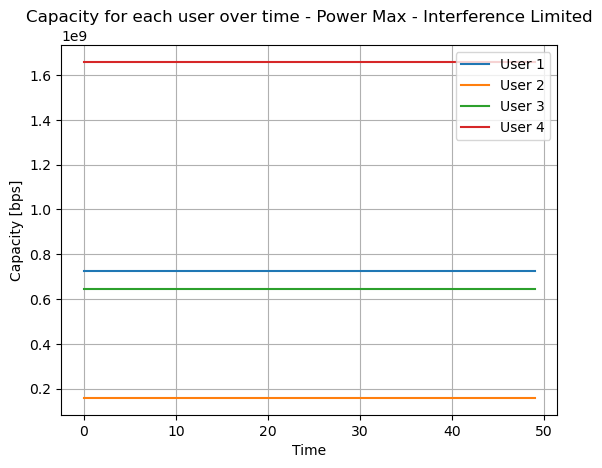

In [697]:
# Plotando a capacidade para cada usuário para cada momento utilizando o Power Max
plt.figure()
plt.plot(capacity_max_vector[0, :], label='User 1')
plt.plot(capacity_max_vector[1, :], label='User 2')
plt.plot(capacity_max_vector[2, :], label='User 3')
plt.plot(capacity_max_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - Power Max - Interference Limited')
plt.grid()
plt.show()


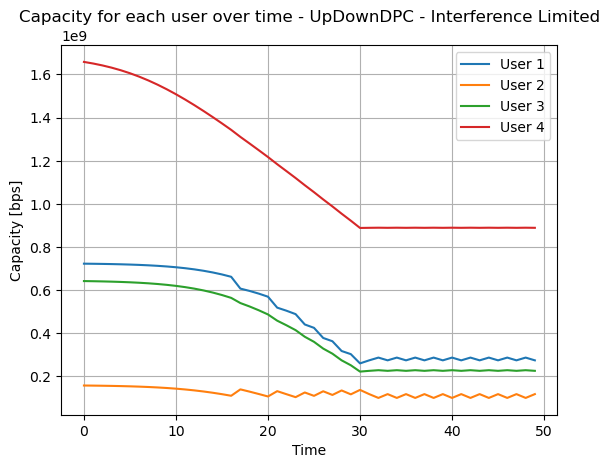

In [698]:
# Plotando a capacidade para cada usuário para cada momento utilizando o UpDownDPC
plt.figure()
plt.plot(capacity_dpc_vector[0, :], label='User 1')
plt.plot(capacity_dpc_vector[1, :], label='User 2')
plt.plot(capacity_dpc_vector[2, :], label='User 3')
plt.plot(capacity_dpc_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Capacity [bps]')
plt.title('Capacity for each user over time - UpDownDPC - Interference Limited')
plt.grid()
plt.show()


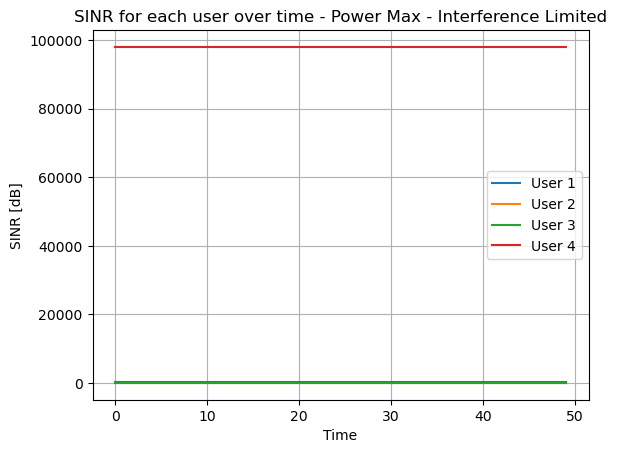

In [699]:
# Plotando a SINR para cada usuário para cada momento utilizando o Power Max
plt.figure()
plt.plot(sinr_max_vector[0, :], label='User 1')
plt.plot(sinr_max_vector[1, :], label='User 2')
plt.plot(sinr_max_vector[2, :], label='User 3')
plt.plot(sinr_max_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - Power Max - Interference Limited')
plt.grid()
plt.show()


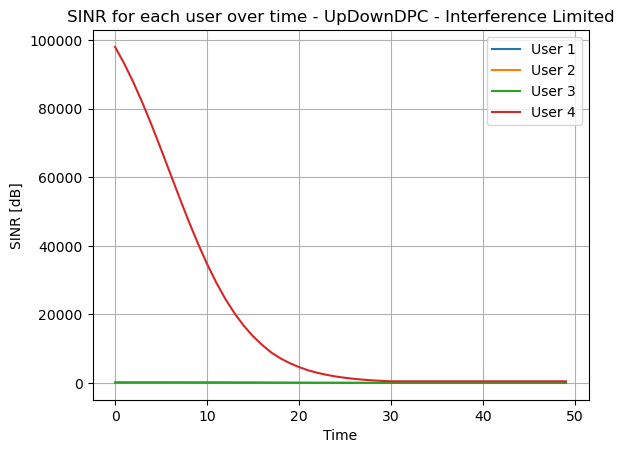

In [700]:
# Plotando a SINR para cada usuário para cada momento utilizando o UpDownDPC
plt.figure()
plt.plot(sinr_dpc_vector[0, :], label='User 1')
plt.plot(sinr_dpc_vector[1, :], label='User 2')
plt.plot(sinr_dpc_vector[2, :], label='User 3')
plt.plot(sinr_dpc_vector[3, :], label='User 4')
plt.legend()
plt.xlabel('Time')
plt.ylabel('SINR [dB]')
plt.title('SINR for each user over time - UpDownDPC - Interference Limited')
plt.grid()
plt.show()
